In [13]:
import torch
import sys
import os
import os.path as osp
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, \
balanced_accuracy_score, accuracy_score
from sklearn import metrics
import math
import cartopy.feature
import cartopy.crs as ccrs

In [14]:
os.environ['USER_PATH']='/home/richras/Ge3Net_Journal/Ge2Net_Repo/'
os.environ['USER_SCRATCH_PATH']="/home/richras/Ge3Net_Journal"
os.environ['OUT_PATH']='/home/richras/Ge3Net_Journal'

In [15]:
os.chdir(os.environ.get('USER_PATH'))

In [22]:
%load_ext autoreload
%autoreload 2
from src.utils.dataUtil import load_path, save_file, vcf2npy
from src.utils.modelUtil import Params, load_model, convert_coordinates
from src.utils.labelUtil import nearestNeighbourMapping, repeat_pop_arr, convert_nVector
from src.utils.decorators import timer
from src.models.modelSelection import modelSelect
from src.models.modelParamsSelection import Selections
from src.models import Model_A, Model_B, Model_C, BOCD
from src.models.distributions import Multivariate_Gaussian
from src.main.evaluation import eval_cp_batch, reportChangePointMetrics, t_prMetrics, cpMethod, eval_cp_matrix, \
getCpPred, GcdLoss
from src.main.settings_model import parse_args
from src.main.dataset import Haplotype
from src.models.Ge3Net import Ge3NetBase
from src.main.visualization import plot_changepoints
import inference

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load the model and use valid data 

In [613]:
# Specify the dataset to be evaluated
# chm22 pca full dataset and model
labels_path = osp.join(os.environ['OUT_PATH'], 'data','data_id_4_geo')
data_path = osp.join(os.environ['OUT_PATH'],'data','data_id_4_geo')
models_path=osp.join(os.environ['OUT_PATH'],'models','Model_Q_exp_id_3_data_id_4_geo/') 
dataset_type='test'

In [614]:
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
config['model.loadBest']=True
yaml_path = osp.join(config['models.dir'], 'params.yaml')
assert osp.isfile(yaml_path), "No yaml configuration file found at {}".format(yaml_path)
params = Params(yaml_path)
params.rtnOuts=True
params.mc_dropout=False
params.mc_samples=100
params.cp_tol=1
params.valid_gens=[0,2,4,8]
params.evalCp=True
params.evalBalancedGcd=True
params.evalExtraMainLosses=True
params.pretrained=False
params.optimizer='AdamW'
results, test_dataset, model, _=inference.main(config, params)

 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: Loading test Dataset
INFO: __init__:src.main.dataset:Loading gen 0
INFO: __init__:src.main.dataset: snps data: (540, 317410)
INFO: __init__:src.main.dataset: y_labels data :(540, 317410)
INFO: __init__:src.main.dataset:Loading gen 2
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 4
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 8
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0670 secs
Finished 'mapping_func' in 0.2455 secs
Finished 'pop_mapping' in 0.0956 secs
Finished 'pop_mapping' in 0.1300 secs
Finished 'transform_data' in 26.7547 secs
Finished '__init__' in 32.0804 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:107528
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31891819
Finished 'load_model' in 0.1554 secs
best val loss metrics : {'loss_main': 866.6805836590546, 'loss_aux': 2160.2513772460106, 'l1_loss': 0.20087590047931303, 'mse': 0.045047710068923504, 'smooth_l1': 0.022466416130238673, 'weighted_loss': 0.20087590047931303}
at epoch : 227
train loss metrics: {'loss_main': 260.368462953392, 'loss_aux': 1561.6972164885574, 'l1_loss': 0.05821169218555197, 'mse': 0.005354038258400175, 'smooth_l1': 0.0026711223615385584, 'weighted_loss': 0.05821169218555197}
best val cp metrics : {'loss_cp': 0.49852718259127005, 'prM

In [615]:
train_dataset = Haplotype("train", params, data_path, labels_path=labels_path)

INFO: __init__:src.main.dataset: Loading train Dataset
INFO: __init__:src.main.dataset:Loading gen 0
INFO: __init__:src.main.dataset: snps data: (4778, 317410)
INFO: __init__:src.main.dataset: y_labels data :(4778, 317410)
INFO: __init__:src.main.dataset:Loading gen 2
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 4
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 8
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 16
INFO: __init__:src.main.dataset: snps data: (400, 317410)
INFO: __init__:src.main.dataset: y_labels data :(400, 317410)
INFO: __init__:src.main.dataset:Loading gen 24
INFO: __init__:src.main.dataset: snps data: (400, 317410)
INFO: _

Finished '_geoConvertLatLong2nVec' in 0.2057 secs
Finished 'mapping_func' in 0.7044 secs
Finished 'pop_mapping' in 0.3010 secs
Finished 'pop_mapping' in 0.2633 secs
Finished 'transform_data' in 75.3451 secs
Finished '__init__' in 90.2128 secs


In [616]:
model.to(params.device)
next(model.parameters()).is_cuda

True

In [617]:
results.t_out.coord_main.shape

(1, 2940, 317, 3)

In [618]:
results.t_accr, results.t_cp_accr

({'loss_main': 828.5692439751926,
  'loss_aux': 2091.7375222644264,
  'l1_loss': 0.1914161604359804,
  'mse': 0.041989554549269434,
  'smooth_l1': 0.02094774887401604,
  'weighted_loss': 0.1914161604359804},
 {'loss_cp': 0.48340312342405417,
  'prMetrics': OrderedDict([('Precision', array(0.05151089)),
               ('Recall', array(0.86810521)),
               ('Accuracy', array(0.72912402)),
               ('A_major', array(0.7267482)),
               ('BalancedAccuracy', 0.7974267027172597)])})

In [619]:
results.t_balanced_gcd

{'meanBalancedGcdSp': 744.737552040442,
 'meanBalancedGcdGp': 930.0702068653264,
 'medianBalancedGcdSp': 782.0093749158385,
 'medianBalancedGcdGp': 793.1285830593874,
 'median': 462.9327087402344}

In [620]:
results_coord_main=results.t_out.coord_main.mean(0)

In [621]:
y_pred = results_coord_main
n_vec_dim=y_pred.shape[-1]
data_tensor = torch.tensor(y_pred).float()
batch_size_cpd = data_tensor.shape[0]
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
mean_var=torch.mean(torch.var(data_tensor, dim =1),dim=0).unsqueeze(0)
cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = cov_prior
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
_,_,_,_=model_cpd.run_recursive(data_tensor, 'cpu')

Finished 'run_recursive' in 74.4540 secs


In [622]:
granular_pop_dict = load_path(osp.join(labels_path, 'granular_pop.pkl'), en_pickle=True)
superop_dict=load_path(osp.join(labels_path, 'superpop.pkl'), en_pickle=True)
pop_sample_map=pd.read_csv(osp.join(labels_path, 'pop_sample_map.tsv'),sep="\t")
pop_arr=repeat_pop_arr(pop_sample_map)
cp_target=test_dataset.data['cps']
seqlen=cp_target.shape[1]
rev_pop_dict={v:k for k,v in granular_pop_dict.items()}
rev_sp_dict={v:k for k,v in superop_dict.items()}

In [623]:
cp_target.shape

(2940, 317)

In [624]:
#index=2747, 2005, 2142, 2422, 2358, 3055, 2495, 2683, 278, 2617, 2531, 829, 823, 2495, 422, 423
#829, 823, 2495, 422, 423, 1788, 1146, 1235, 2550, 2590
#colombian 1322, 645, 508, 2556, 1038, 2825, 2590- for a failure case
#karitiana 748 and 1920 (also a good overall) ,2350, 549, 1909
#surui 1400, 838, 1010, 1327, 1236

In [625]:
# index = 2500
# index=2620
# index=2650
# index=3000
# index=3100
# index=2300
# index=2320
# index=2338 #interesting Mansi pop
# index=2339 # nice example showing Karitiana
# index=2344 #interesting clusters of Mongolia
# index=2346 # interesting African diversity
# index=2355#int. Iranian sample
# index=2366# Piapioco and Pima both
# index=2388#int example
# index=2398#Biaka/Luhya
# index=2403#Quechua
# index=2414#incorrect Khomani San
# index=2421#uyugur
# index=2465#balochi similar to MAkrani slave trade
# index=2482# interesting Indo euro
# index=2876 #icelandic example
# index=3533 #San and icelandic
# index=1007 #Surui
# index=2974 #Surui nice example
# index=1873# nice diversity of samples
# index=np.random.choice(idxOfInterest)
# index=830
# index=511
# index=1040 #San
# index=2205#1007 #2205, for 3_geo
# index=1169
index=1920
print(index)
true_cpsSample=cp_target[index,:]
y_predSample=results_coord_main[index,:]
y_trueSample=test_dataset.data['y'][index,:]
granularpopSample=test_dataset.data['granular_pop'][index,:]
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
superPopSample=test_dataset.data['superpop'][index,:]
SpNamesSample=[rev_sp_dict[i] for i in superPopSample.astype(int)]

1920


In [626]:
pred_cps=getCpPred(cpMethod.gradient.name, y_predSample, 0.1, 1, len(true_cpsSample))
pred_cps=pred_cps.squeeze(0).detach().cpu().numpy()# squeeze the batch dimension of 1

In [627]:
predBOCDSample=model_cpd.cp[index,:]
pred_cps_BOCD=getCpPred(cpMethod.BOCD.name, predBOCDSample, 5.0, 1, len(true_cpsSample))
pred_cps_BOCD=pred_cps_BOCD.squeeze(0).detach().cpu().numpy()# squeeze the batch dimension of 1

In [628]:
cpIdx=np.nonzero(pred_cps_BOCD)[0]
remWin=3
for i in cpIdx:
    low=max(0,i-remWin)
    high=min(seqlen, i+remWin)
    pred_cps_BOCD[low:high]=1

In [629]:
mappedSpArr=nearestNeighbourMapping(labels_path, y_predSample.reshape(-1,3))
# mappedSpArr=mappedSpArr.squeeze(1)

Finished 'nearestNeighbourMapping' in 0.0744 secs


In [630]:
y_predsTrue=test_dataset.data['y'].reshape(-1,3)
superpopsTrue=test_dataset.data['superpop'].reshape(-1,)

In [631]:
@timer
def plot_sample(granularPopSample, y_predSample, y_trueSample, **kwargs):
    backgroundAxis=kwargs.get('backgroundAxis')
    y_predCps=kwargs.get('y_predCps')
    y_preds=kwargs.get('y_preds')
    superpops=kwargs.get('superpops')
    cpShow=kwargs.get('cpShow')
    pred_cps=kwargs.get('pred_cps')
    mappedSpArr=kwargs.get('mappedSpArr')
    fig, ax = plt.subplots(figsize=(12,14))
    
    gs1 = fig.add_gridspec(nrows=3, ncols=1, height_ratios=[13,1,1])
    ax1=fig.add_subplot(gs1[0],projection='3d')
    ax2=fig.add_subplot(gs1[1])
    ax3=fig.add_subplot(gs1[2])
    for axis in [ax, ax2, ax3]:
        axis.set_yticks([])
        axis.spines['top'].set_color('none')
        axis.spines['left'].set_color('none')
        axis.spines['right'].set_color('none')
    ax.set_xticks([])
    plt.subplots_adjust(hspace=0.01)
    
    if backgroundAxis is not None:
        lgnd, colorsPop_sp_dict =plot_all(ax1, y_preds, superpops, cpShow=False)
    else:
        continentaPops=list(superop_dict.values())
        colors_Sp = sns.color_palette("bright", 10)
        del colors_Sp[1]
        del colors_Sp[4]
        del colors_Sp[5]
        colorsPop_sp_dict = {k:v for k,v in zip(continentaPops, colors_Sp)}
        colorsPop_sp_dict[-1]=(0.7,0.7,0.7) # grey color
        patches=[]
        for k, val in superop_dict.items():
            patches.append(mpatches.Patch(color = colorsPop_sp_dict[val], label = k))
        lgnd = ax1.legend(handles=patches, loc="upper right",fontsize=15)
    ax1.add_artist(lgnd)    
    colors_pop = sns.color_palette("rainbow", len(np.unique(granularPopSample)))
    colors_pop_dict = {k:v for k,v in zip(np.unique(granularPopSample), colors_pop)}

    alpha=[1]*len(y_predSample)
    if cpShow is None:
#         alpha=(pred_cps==0).astype(float)
        unknownIdx=np.nonzero(pred_cps)[0]
        print(f"number of changepoints removed:{len(unknownIdx)},{len(unknownIdx)/len(y_predSample)}")
        granularPopNames=["UNK" if i in unknownIdx else granularPopSample[i] for i in range(len(granularPopSample))]
        colors_pop_dict["UNK"]=(0.9,0.9,0.9) # grey color
        mappedSpArr[unknownIdx]=-1
    
    ax1.scatter(y_predSample[:,0], y_predSample[:,1], y_predSample[:,2], \
               color = [colors_pop_dict[x]+(y,) for x,y in zip(granularPopNames, alpha)], s=50, zorder=0) 
    ax1.scatter(y_trueSample[:,0], y_trueSample[:,1], y_trueSample[:,2], \
               color = [colors_pop_dict[x] for x in granularPopSample], marker='X', s=200, zorder=0)
    
    for axis in [ax1.xaxis, ax1.yaxis, ax1.zaxis]:
        axis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        axis._axinfo["grid"]['color'] = (1,1,1,0)
    patches=[]
    for i, val in enumerate(np.unique(granularPopSample)):
        patches.append(mpatches.Patch(color = colors_pop_dict[val], label = val))
    patches.append(mpatches.Patch(color = (0.9,0.9,0.9), label = "UNK"))
    ax1.legend(handles=patches, loc="upper left", fontsize=20)
    
    #chm plot ground truth
    ax2.scatter(np.arange(len(y_trueSample)),np.ones(len(y_trueSample)),\
                color=[colors_pop_dict[x] for x in granularPopSample], marker='s')
    ax2.set_title('Labeled Chromosome22', fontsize=30, y=0.3)
    #chm plot of predictions
    ax3.scatter(np.arange(len(mappedSpArr)),np.ones(len(mappedSpArr)),\
                color=[colorsPop_sp_dict[x]+(y,) for x,y in zip(mappedSpArr,alpha)], marker='s')
    ax3.set_title('Predicted Chromosome22', fontsize=30, y=0.3)
    
    for ax in [ax2, ax3]:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(4))
        ax.xaxis.set_ticks_position('bottom')
        ax.tick_params(which='major', width=2, length=10, labelsize=25)
        ax.tick_params(which='minor', width=2, length=10, labelsize=10)
        ax.set_xlim(0, 316)
        ax.set_ylim(0.99,1.09)
        positions = [0, 160, 300]
        x_labels = [0, 150000, 317000]
        ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
        ax.xaxis.set_major_formatter(ticker.FixedFormatter(x_labels))
    
    fig.tight_layout()
    plt.show()
    plt.close('all')

number of changepoints removed:24,0.07570977917981073


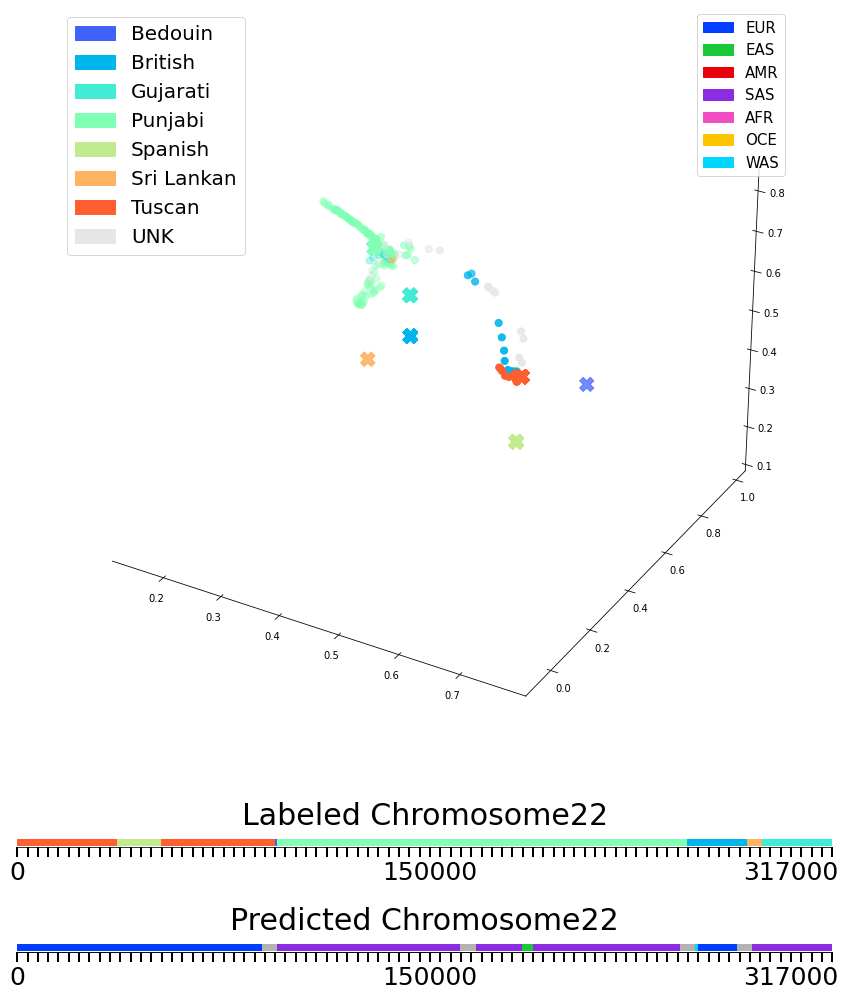

Finished 'plot_sample' in 1.1044 secs


In [632]:
plot_sample(namesSample, y_predSample, y_trueSample, pred_cps=pred_cps_BOCD, mappedSpArr=mappedSpArr)

In [633]:
def plot_coordinates_map(granularPopNames, pred_coord, lbl_coord, **kwargs):
    """
    plotly plot for coordinates on a map
    label: target label vector (int) for the specific sample
    data_coordinates: lat, long for the specific sample
    rev_pop_order: dict with keys as target label ints and values
    as granular population name
    """
    cpShow=kwargs.get('cpShow')
    pred_cps=kwargs.get('pred_cps') 
    alpha=[1.0]*len(lbl_coord)
    if cpShow:
        unknownIdx=np.nonzero(pred_cps)[0]
        granularPopNames=["UNK" if i in unknownIdx else granularPopNames[i] for i in range(len(granularPopNames))]
    fig = go.Figure(go.Scattergeo())
    colors_pop = sns.color_palette("rainbow", len(np.unique(granularPopNames)))
    
    colors_pop_dict = {k:v for k,v in zip(np.unique(granularPopNames), colors_pop)}
    colors_pop_dict['UNK']=(188,188,188) # grey color
    fig.add_trace(go.Scattergeo(lon=pred_coord[:,1], lat=pred_coord[:,0], text = granularPopNames,\
    marker_color=['rgba'+str(colors_pop_dict[x]+(y,)) for x,y in zip(granularPopNames, alpha)]))
    fig.update_traces(marker_size = 5)
    fig.add_trace(go.Scattergeo(lon=lbl_coord[:,1], lat=lbl_coord[:,0], marker = dict(symbol = 'square'), \
                                text = granularPopNames))
    fig.update_traces(marker_size = 5)

    fig.show()
    plt.show()
    plt.close('all')

In [634]:
def plot_coordinates_map_cartopy(granularPopSample, pred_coord, lbl_coord, all_lbl_coord, **kwargs):
    cpShow=kwargs.get('cpShow')
    pred_cps=kwargs.get('pred_cps') 
    superPopSample=kwargs.get('superPopSample')
    alpha=[1.0]*len(lbl_coord)
    
    fig, ax = plt.subplots(figsize=(35,18))
    
    gs1 = fig.add_gridspec(nrows=3, ncols=1, height_ratios=[20,2,2])
    ax1=fig.add_subplot(gs1[0],projection=ccrs.PlateCarree())
    ax2=fig.add_subplot(gs1[1])
    ax3=fig.add_subplot(gs1[2])
    for axis in [ax, ax2, ax3]:
        axis.set_yticks([])
        axis.spines['top'].set_color('none')
        axis.spines['left'].set_color('none')
        axis.spines['right'].set_color('none')
    ax.set_xticks([])
    plt.subplots_adjust(hspace=0.01)

    ax1.add_feature(cartopy.feature.OCEAN, facecolor=("lightblue"), alpha=0.8)
    ax1.add_feature(cartopy.feature.LAND, alpha =0.3)
    ax1.add_feature(cartopy.feature.COASTLINE, alpha =0.5)
    
    x_min=np.min(pred_coord[:,1])-5
    x_max=np.max(pred_coord[:,1])+5
    y_min=np.min(pred_coord[:,0])-5
    y_max=np.max(pred_coord[:,0])+5
    ax1.set_extent([x_min, x_max, y_min, y_max], ccrs.PlateCarree())
    ax1.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())
    
    continentaPops=list(superop_dict.values())
    colors_Sp = sns.color_palette("bright", 10)
    del colors_Sp[1]
    del colors_Sp[4]
    del colors_Sp[5]
    colorsPop_sp_dict = {k:v for k,v in zip(continentaPops, colors_Sp)}
    patches=[]
    for k, val in superop_dict.items():
        patches.append(mpatches.Patch(color = colorsPop_sp_dict[val], label = k))
    lgnd = ax1.legend(handles=patches, loc="lower left", fontsize=40, bbox_to_anchor=(-0.15, 0.49, 1., .5))
    ax1.add_artist(lgnd)
    
    patches=[]
    colors_Gp_dict,_,_=getColorsPop(granularpopSample, superPopSample, colorsPop_sp_dict)
    colors_pop_dict=colors_Gp_dict
    colors_pop_dict[-1]=(0.9,0.9,0.9) # grey color

    alpha=[1]*len(pred_coord)
    
    unknownIdx=np.nonzero(pred_cps)[0]
    print(f"number of changepoints removed:{len(unknownIdx)},{len(unknownIdx)/len(pred_coord)}")
    granularPopNames=["UNK" if i in unknownIdx else granularPopSample[i] for i in range(len(granularPopSample))]
    colors_pop_dict["UNK"]=(0.9,0.9,0.9) # grey color
    mappedSpArr[unknownIdx]=-1
    colorsPop_sp_dict[-1]=(0.9,0.9,0.9) # grey color
    knownIdx=[i for i in range(len(granularPopNames)) if granularPopNames[i]!="UNK"]
    
        
    # predictions
    ax1.scatter(pred_coord[knownIdx,1], pred_coord[knownIdx,0], edgecolor='grey', linewidth=1.5,\
    color = [tuple(colors_pop_dict[x])+(y,) for x,y in zip([granularPopNames[i] for i in knownIdx], alpha)], \
                s=250, zorder=0.5)
    
    # changepoints
    if cpShow is True:
        ax1.scatter(pred_coord[unknownIdx,1], pred_coord[unknownIdx,0], facecolor='grey', hatch=3*'+', marker="D",\
        color = [tuple(colors_pop_dict[x])+(y,) for x,y in zip([granularPopNames[i] for i in unknownIdx], alpha)], \
                    s=350, zorder=0.1) 
    
    #ground truth
    #ToDo: plot only the unique trueSample instead of all the windows
    ax1.scatter(lbl_coord[:,1], lbl_coord[:,0], linewidth=1, \
    color = 'black', marker='X', s=500, zorder=0.2)
    
    #training locations
    ax1.scatter(all_lbl_coord[1].values, all_lbl_coord[0].values, transform=ccrs.PlateCarree(),\
               color = 'black', marker='x', s=500, linewidth=1, alpha=0.5)

    
    patches=[]
    for i, val in enumerate(np.unique(granularPopSample)):
        patches.append(mpatches.Patch(color = colors_pop_dict[val], label = rev_pop_dict[val]))
    patches.append(mpatches.Patch(facecolor = (0.9,0.9,0.9), label = "Changepoint", hatch=1*'+'))
    patches.append(mpatches.Patch(color = 'grey', label = "Training Locations"))
    patches.append(mpatches.Patch(color = 'black', label = "Target Locations"))
    ax1.legend(handles=patches, loc="upper left", fontsize=40)

    #chm plot ground truth
    ax2.bar(np.arange(len(y_trueSample)),\
    color=[colors_pop_dict[x] for x in granularPopSample], width=1.0, height=1.04)

    ax2.set_title('Labeled Chromosome22', fontsize=70, y=0.5)
    ax3.bar(knownIdx, 1.04*np.ones(len(mappedSpArr[knownIdx])), \
            color=[colorsPop_sp_dict[x]+(y,) for x,y in zip(mappedSpArr[knownIdx],alpha)], \
            width=1.0)
    ax3.bar(unknownIdx, 1.04*np.ones(len(mappedSpArr[unknownIdx])), \
        color=[colorsPop_sp_dict[x]+(y,) for x,y in zip(mappedSpArr[unknownIdx],alpha)], \
        width=1.0, hatch=1*"+")
    ax3.set_title('Predicted Chromosome22', fontsize=70, y=0.5)

    for ax in [ax2, ax3]:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(4))
        ax.xaxis.set_ticks_position('bottom')
        ax.tick_params(which='major', width=2, length=10, labelsize=50)
        ax.tick_params(which='minor', width=2, length=10, labelsize=10)
        ax.set_xlim(0, 316)
        ax.set_ylim(0.99,1.09)
        positions = [0, 160, 300]
        x_labels = [0, 150000, 317000]
        ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
        ax.xaxis.set_major_formatter(ticker.FixedFormatter(x_labels))

    fig.tight_layout()
    plt.show()
    plt.close('all')

In [635]:
def getColorsPop(granularpopSample, superPopSample, colorsSP_dict):
    counterSPUsed={k:0 for k in range(7)}
    haploGp ={}
    gpMap2Sp_Color={}
    for i in np.unique(granularpopSample):
        idx=np.nonzero(granularpopSample==i)[0][0]
        sp=superPopSample[idx]
        colorIdx=3*counterSPUsed[sp]+3 # because we want to pick alternate colors separated by 2 hops
        gpMap2Sp_Color[i]=(sp,colorIdx)
        counterSPUsed[sp] +=1
    
    spGradient=getGradient(counterSPUsed, colorsSP_dict)
    
    for i in np.unique(granularpopSample):
        haploGp[i]=spGradient[gpMap2Sp_Color[i][0]][gpMap2Sp_Color[i][1]]
    
    return haploGp, counterSPUsed, gpMap2Sp_Color

In [636]:
def linear_gradient(start_rgb, finish_rgb, n):
    ''' returns a gradient list of (n) colors between
      two rgb colors. start_rgb and finish_rgb
       '''
    # Initilize a list of the output colors with the starting color
    RGB_list = [start_rgb]
    # Calcuate a color at each evenly spaced value of t from 1 to n
    for t in range(1, n):
        # Interpolate RGB vector for color at the current value of t
        curr_vector = [
            (start_rgb[j] + (float(t)/(n-1))*(finish_rgb[j]-start_rgb[j]))
            for j in range(3)
        ]
        # Add it to our list of output colors
        RGB_list.append(curr_vector)
    
    return RGB_list

In [637]:
continentaPops=list(superop_dict.values())
colorsPop = sns.color_palette("bright", 10)
del colorsPop[1]
del colorsPop[4]
del colorsPop[5]
colorsSP_dict = {k:v for k,v in zip(continentaPops, colorsPop)}

def getGradient(counterSPUsed, colorsSP_dict):
    spGradient={}
    for k,v in colorsSP_dict.items():
        if counterSPUsed[k]>0:
            if k<=len(colorsSP_dict)-2:
                finish_rgb=k+1
            else:
                finish_rgb=0
#             if k == 3:
#                 spGradient[k]=linear_gradient(start_rgb=[147.0/255.0, 112.0/255.0, 219.0/255.0], finish_rgb=[139.0/255.0, 0.0/255.0, 139.0/255.0],\
#                 n= max(15,3*counterSPUsed[k]+3))                
#             else:
#                 spGradient[k]=linear_gradient(start_rgb=v, finish_rgb=colorsSP_dict[finish_rgb],\
#                 n= max(15,3*counterSPUsed[k]+3))
            spGradient[k]=linear_gradient(start_rgb=v, finish_rgb=[1.0, 1.0, 1.0],\
            n= max(10,3*counterSPUsed[k]+3))

    return spGradient
    
colors_Gp_dict, counterSPUsed, gpMap2Sp_Color=getColorsPop(granularpopSample, superPopSample, colorsSP_dict)

number of changepoints removed:24,0.07570977917981073


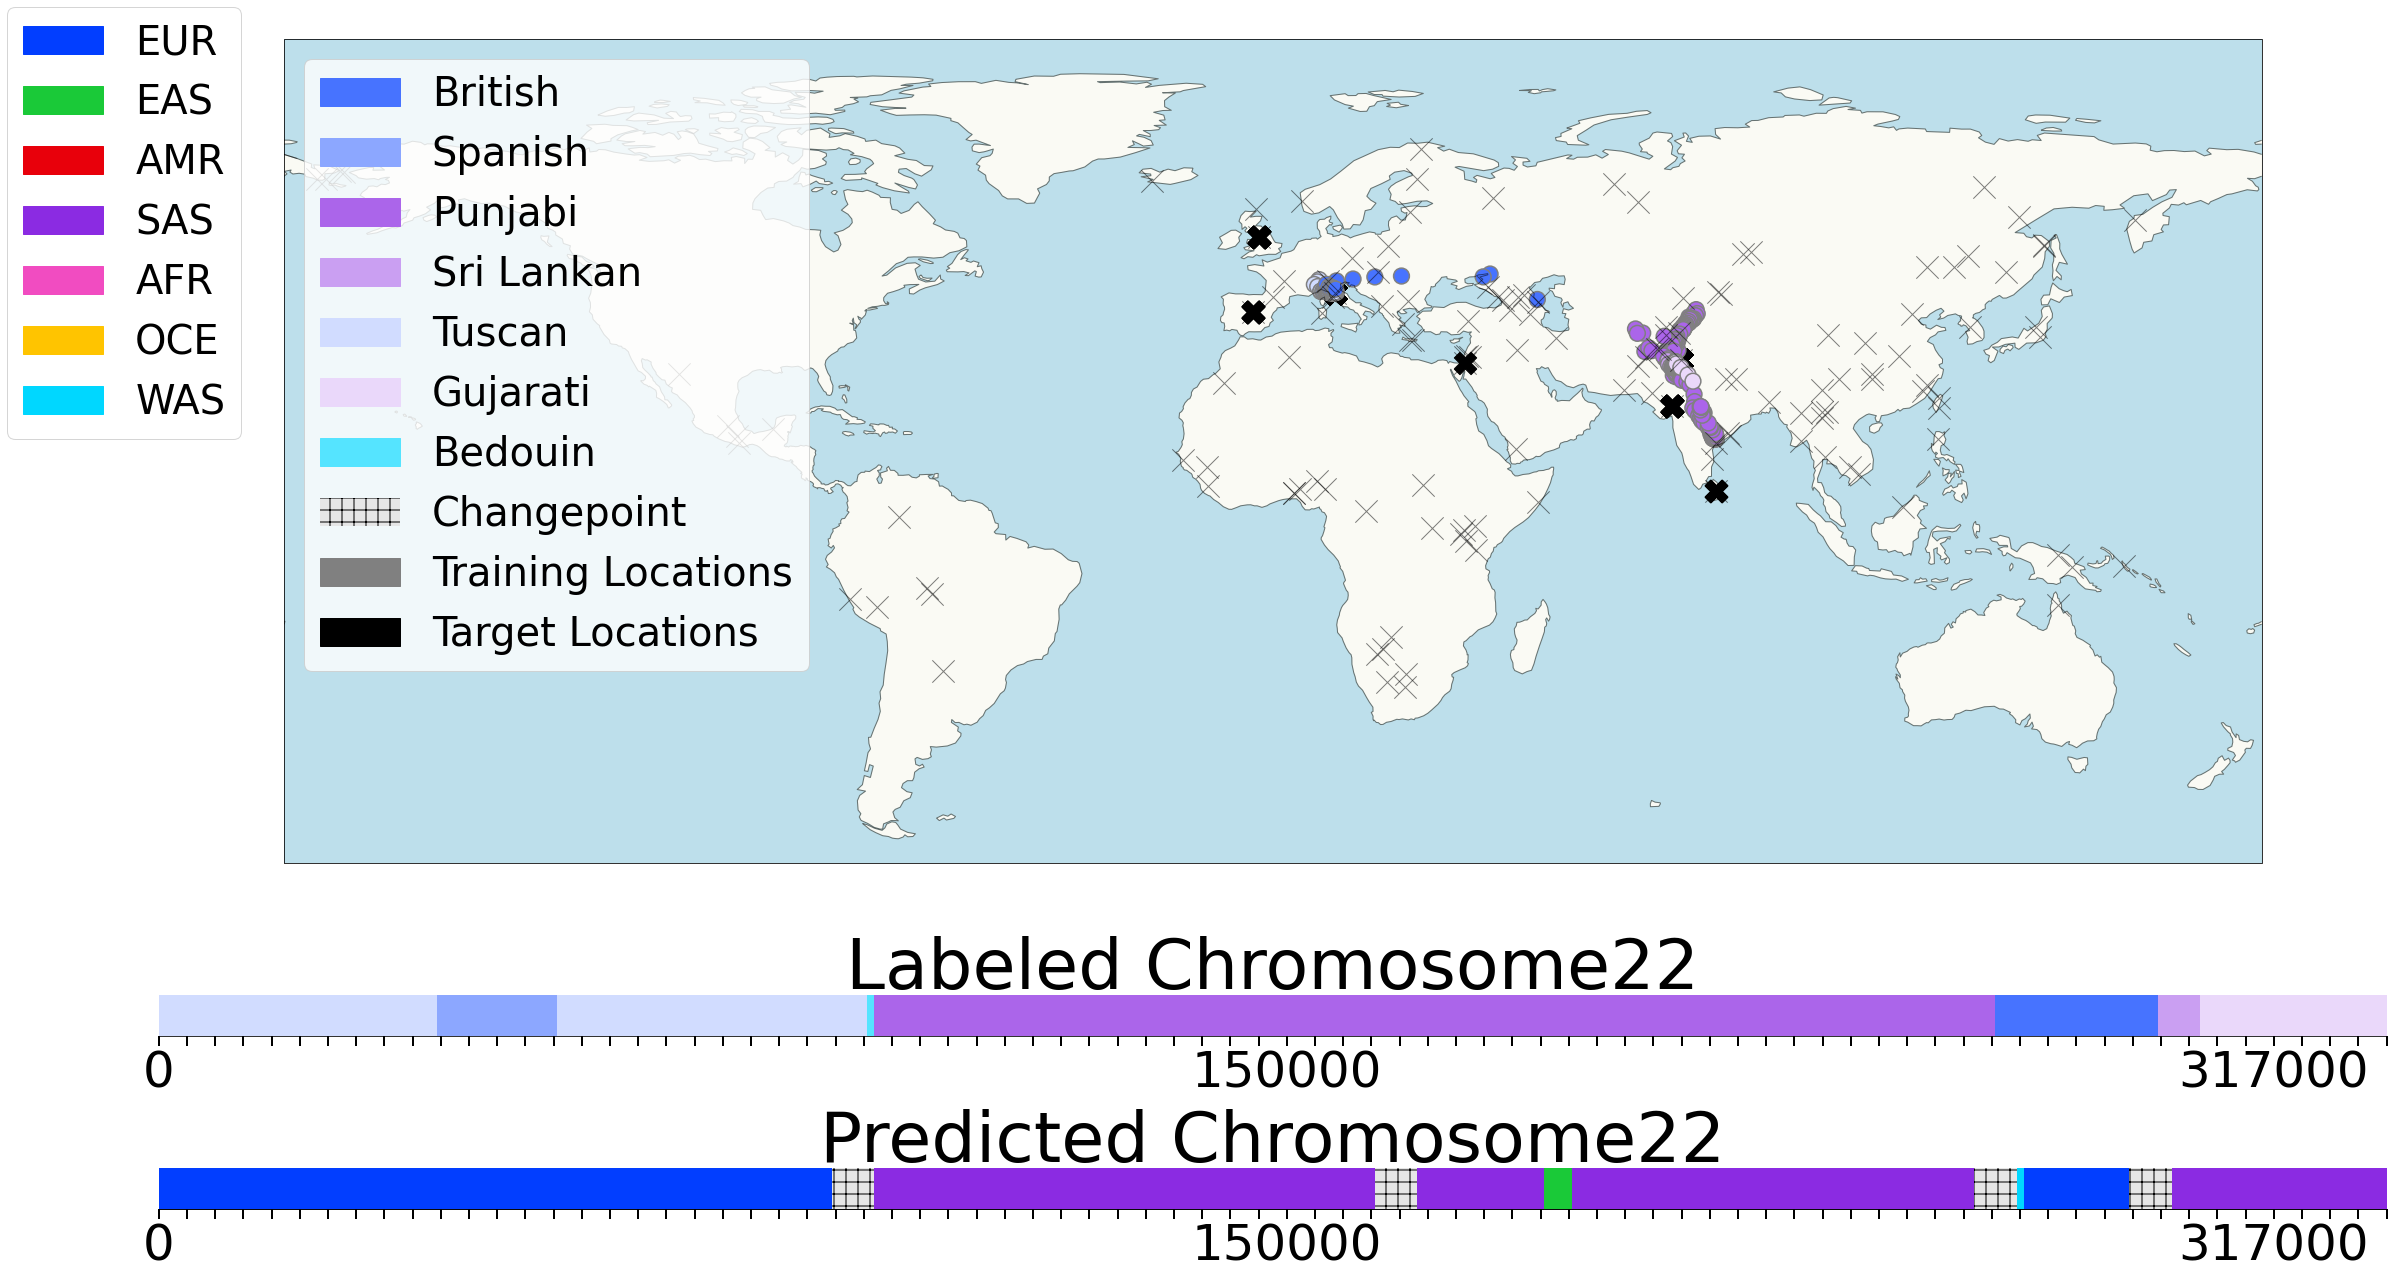

In [638]:
lbl_coord=convert_coordinates(y_trueSample[:,0], y_trueSample[:,1], y_trueSample[:,2])
pred_coord=convert_coordinates(y_predSample[:,0], y_predSample[:,1], y_predSample[:,2])
unique_coord = train_dataset.data['y']
labels_all=load_path(osp.join(labels_path, 'labels.pkl'), en_pickle=True)
train_sample_map=pd.read_csv(osp.join(labels_path, 'train_sample_map.tsv'), sep="\t")
pop_arr_train = repeat_pop_arr(train_sample_map)
n_dim=2
labelsTrainArr=np.zeros((len(pop_arr_train), n_dim))
for i,j in enumerate(pop_arr_train[:,1]):
    labelsTrainArr[i,:]=labels_all.get(j) #5930x3 #samplesxdim
df_trainLabels=pd.DataFrame(labelsTrainArr)
df_trainLabels=df_trainLabels.drop_duplicates()
df_trainLabels
granularPopNames=namesSample
plot_coordinates_map_cartopy(granularpopSample, pred_coord, lbl_coord, df_trainLabels, \
                             pred_cps=pred_cps_BOCD, cpShow=False,superPopSample=superPopSample)

In [472]:
colors_Gp_dict

{4: [0.338562091503268, 0.4954248366013072, 1.0],
 30: [0.9633986928104575, 0.5320261437908497, 0.8379084967320262],
 39: [0.9398692810457516, 0.3333333333333333, 0.36209150326797385],
 40: [0.4013071895424837, 0.8588235294117647, 0.47973856209150323],
 85: [0.9699346405228758, 0.6666666666666666, 0.6810457516339868]}

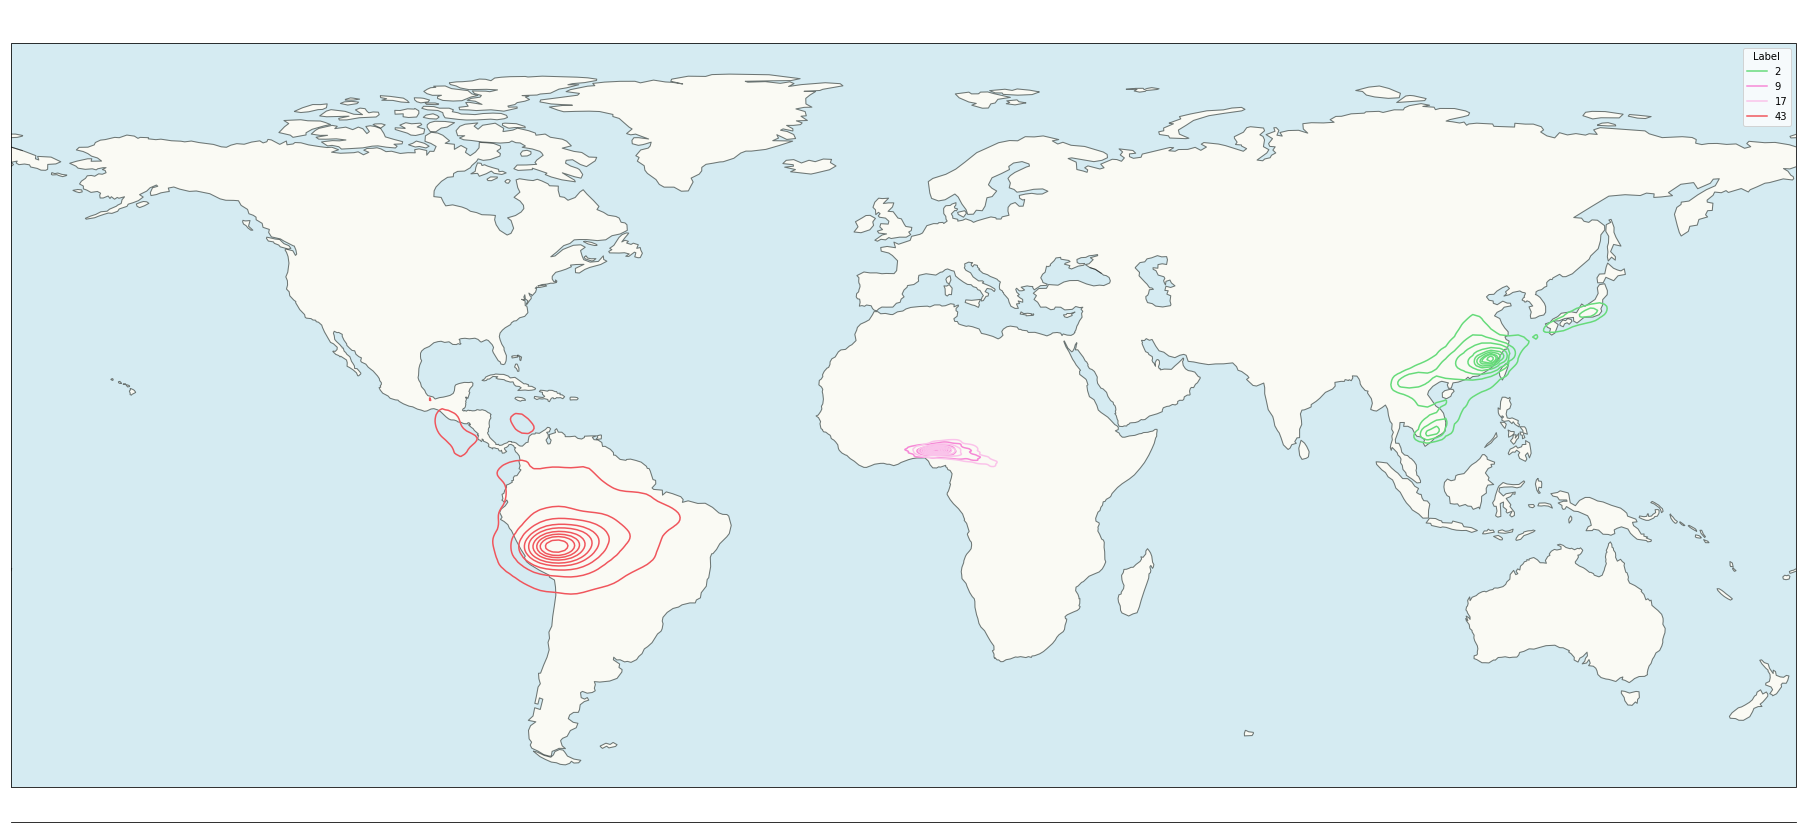

In [416]:
#kde plot
mc_pred=results.t_out.coord_main[:,index,...]
unknownIdx=np.nonzero(pred_cps)[0]
knownIdx=np.delete(np.arange(317), unknownIdx)
granularpopSample_mc=granularpopSample[knownIdx]
granularpopSample_mc=np.repeat(granularpopSample_mc[np.newaxis,...],100,0).reshape(-1)

mc_pred=mc_pred[:,knownIdx,:].reshape(-1,3)
mc_pred_coord=convert_coordinates(mc_pred[:,0], mc_pred[:,1], mc_pred[:,2])
fig, ax = plt.subplots(figsize=(32,15))
    
gs1 = fig.add_gridspec(nrows=1, ncols=1)
ax1=fig.add_subplot(gs1[0],projection=ccrs.PlateCarree())
for axis in [ax]:
    axis.set_yticks([])
    axis.spines['top'].set_color('none')
    axis.spines['left'].set_color('none')
    axis.spines['right'].set_color('none')
ax.set_xticks([])
plt.subplots_adjust(hspace=0.01)

x_min=np.min(pred_coord[:,1])-25
x_max=np.max(pred_coord[:,1])+25
y_min=np.min(pred_coord[:,0])-25
y_max=np.max(pred_coord[:,0])+25
ax1.set_extent([x_min, x_max, y_min, y_max], ccrs.PlateCarree())

ax1.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())
ax1.add_feature(cartopy.feature.OCEAN, facecolor=("lightblue"), alpha=0.5)
ax1.add_feature(cartopy.feature.LAND, alpha =0.3)
ax1.add_feature(cartopy.feature.COASTLINE, alpha =0.5)
df_kde = pd.DataFrame({ 'Long':mc_pred_coord[:,1], 'Lat':mc_pred_coord[:,0], 'Label':granularpopSample_mc})
sns.kdeplot(data=df_kde, x="Long", y = "Lat", hue="Label", palette=colors_Gp_dict,\
fill=False, thresh=0.05, common_norm=False)

plt.show()


In [417]:
mc_pred_coord[:,1].shape, mc_pred_coord[:,0].shape

((31000,), (31000,))

In [400]:
granularpopSample_mc.shape, df_kde.shape

((31300,), (31300, 3))

In [202]:
lbl_coord=convert_coordinates(y_trueSample[:,0], y_trueSample[:,1], y_trueSample[:,2])
pred_coord=convert_coordinates(y_predSample[:,0], y_predSample[:,1], y_predSample[:,2])
granularPopNames=namesSample
plot_coordinates_map(granularPopNames, pred_coord, lbl_coord, pred_cps=pred_cps_BOCD, cpShow=True)

In [85]:
def rawGcd(self, input_y, target):
    if torch.is_tensor(input_y):
        return torch.acos(torch.sum(input_y * target, dim=-1).clamp(-1.0 + self.eps, 1.0 - self.eps)) * self.earth_radius
    elif isinstance(input_y, np.ndarray):
        return np.arccos(np.clip(np.sum(input_y * target, axis=-1), a_min=-1.0 + self.eps, a_max=1.0 - self.eps)) * self.earth_radius

In [86]:
def gcd_loss(y_pred, y, mask=None):
    if mask is not None: 
        print(mask.shape)
        mask=mask.astype(int)
    if mask is None:
        mask = 1
    eps = 1e-4
    temp = np.arccos(np.clip(np.sum(y_pred * y, axis=-1),a_min=-1.0 + eps, a_max=1.0 - eps)).reshape(-1,1)
    sum_gcd = np.sum(temp * 6371 * mask)
    return sum_gcd

In [87]:
def plot_changepoints(true_cps, pred_cps, y_pred, bocp_rl, y_var, popNames):
    fig, ax = plt.subplots(4,1,figsize=[18,20])
    T=len(true_cps)
    ax[0].plot(y_pred)
    ax[0].text(0, np.max(y_pred)-0.5, s=popNames[0], size=15)
    for i in np.nonzero(true_cps)[0]:
        ax[0].plot([i,i], [np.min(y_pred), np.max(y_pred)], 'r' )
        ax[0].text(i, np.max(y_pred)-0.5, s=popNames[i+1], size=15)
    
    ax[1].plot(np.arange(T+1), bocp_rl)
    ax[2].plot(pred_cps)
    ax[3].plot(true_cps)
    
    ax[0].set_title("n_vectors")
    ax[1].set_title("BOCD (post process) run_length")
    ax[2].set_title("BOCD (post process) cp")
    ax[3].set_title("True Cps")
    plt.show()

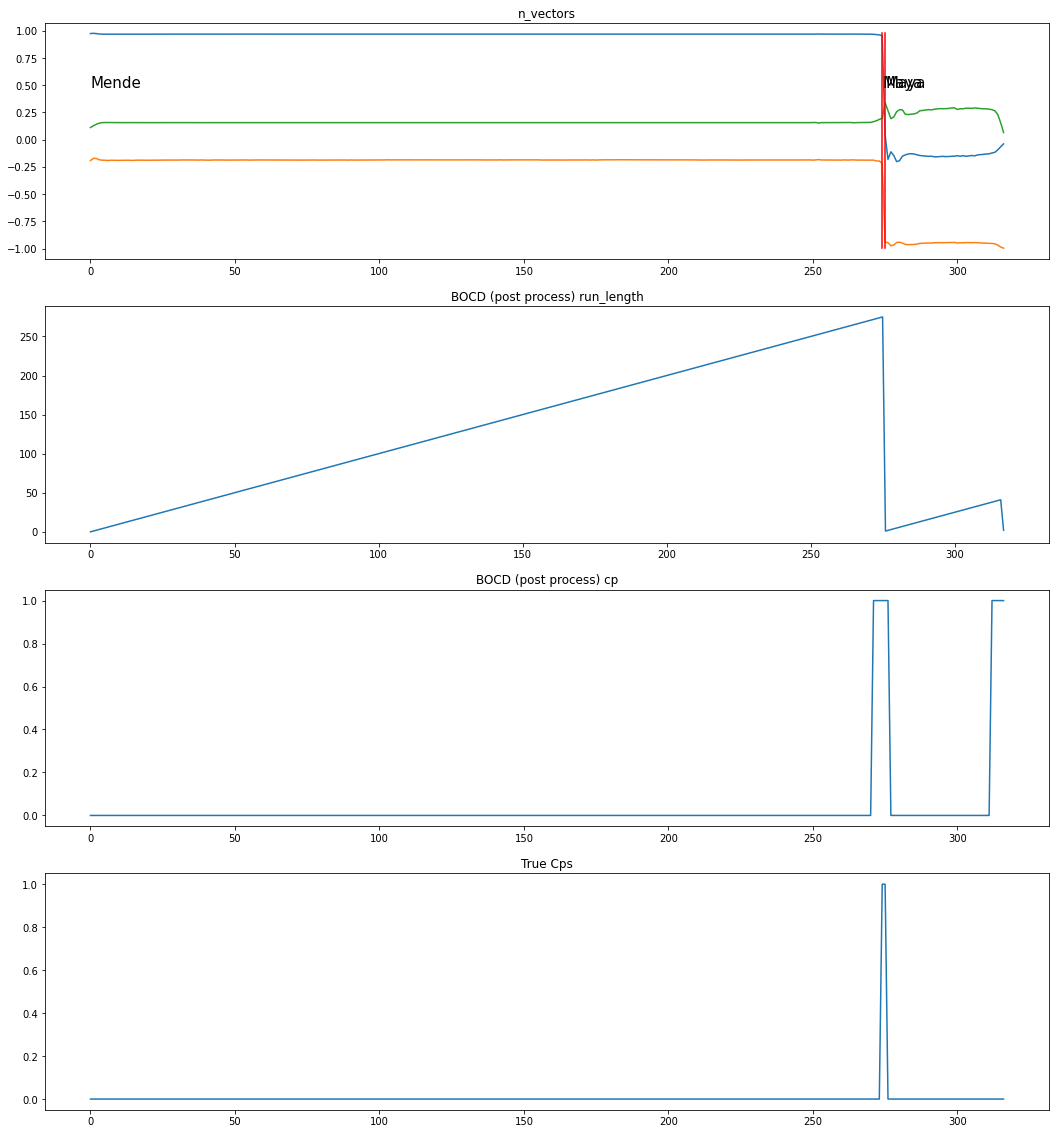

In [88]:
y_var=y_predSample[:,1:]-y_predSample[:,:-1]
bocp_rlSample=model_cpd.cp.detach().cpu().numpy()[index,:]
plot_changepoints(true_cpsSample, pred_cps_BOCD, y_predSample, bocp_rlSample, y_var, namesSample)

In [89]:
idxOfInterest1=np.unique(np.nonzero(test_dataset.data['granular_pop']==granular_pop_dict["Karitiana"])[0])
idxOfInterest2=np.unique(np.nonzero(test_dataset.data['granular_pop']==granular_pop_dict["Korean"])[0])

# idxOfInterest3=np.unique(np.nonzero(test_dataset.data['granular_pop']==granular_pop_dict["Spanish"])[0])
idxOfInterest=np.intersect1d(idxOfInterest1, idxOfInterest2)
# idxOfInterest=np.intersect1d(idxOfInterest, idxOfInterest3)

In [90]:
idxOfInterest

array([], dtype=int64)

In [91]:
@timer
def plot_all(ax, y_preds, superpops, **kwargs):
    cpShow=kwargs.get('cpShow')
    pred_cps=kwargs.get('pred_cps')    
    continentaPops=list(superop_dict.values())
    colors_pop = sns.color_palette("bright", 10)
    del colors_pop[1]
    del colors_pop[4]
    del colors_pop[5]
    colors_pop_dict = {k:v for k,v in zip(continentaPops, colors_pop)}
    
    alpha=[0.03]*len(y_preds)
    if cpShow is None:
        alpha=(pred_cps==0).astype(float)
    
    ax.scatter(y_preds[:,0], y_preds[:,1], y_preds[:,2], \
               color = [colors_pop_dict[x]+(y,) for x,y in zip(superpops, alpha)], marker=".", s=0.05,zorder=-1) 
    
    patches=[]
    for k, val in superop_dict.items():
        patches.append(mpatches.Patch(color = colors_pop_dict[val], label = k))
    lgnd = ax.legend(handles=patches, loc="upper right", fontsize=15)
    return lgnd, colors_pop_dict


In [92]:
y_preds=results.t_out.coord_main
y_predCps=getCpPred(cpMethod.gradient.name, y_predSample, 0.1, y_preds.shape[0], y_preds.shape[1])
y_predCps=y_predCps.reshape(-1,)
y_preds=y_preds.reshape(-1,3)
superpops=test_dataset.data['superpop'].reshape(-1,)

In [93]:
granular_pop_dict

{'British': 0,
 'Finnish': 1,
 'Southern Han Chinese': 2,
 'Dai Chinese': 3,
 'Spanish': 4,
 'Peruvian': 5,
 'Punjabi': 6,
 'Kinh Vietnamese': 7,
 'Gambian Mandinka': 8,
 'Esan': 9,
 'Bengali': 10,
 'Mende': 11,
 'Sri Lankan': 12,
 'Indian Telugu': 13,
 'Yoruba': 14,
 'Han Chinese': 15,
 'Japanese': 16,
 'Luhya': 17,
 'Mexican-American': 18,
 'Tuscan': 19,
 'Gujarati': 20,
 'Brahui': 21,
 'Balochi': 22,
 'Hazara': 23,
 'Makrani': 24,
 'Sindhi': 25,
 'Pathan': 26,
 'Kalash': 27,
 'Burusho': 28,
 'Mbuti': 29,
 'Biaka': 30,
 'Bougainville': 31,
 'French': 32,
 'PapuanSepik': 33,
 'PapuanHighlands': 34,
 'Druze': 35,
 'Bedouin': 36,
 'Sardinian': 37,
 'Palestinian': 38,
 'Colombian': 39,
 'Cambodian': 40,
 'Han': 41,
 'Orcadian': 42,
 'Surui': 43,
 'Maya': 44,
 'Russian': 45,
 'Mandenka': 46,
 'Yakut': 47,
 'San': 48,
 'BantuSouthAfrica': 49,
 'Karitiana': 50,
 'Pima': 51,
 'Tujia': 52,
 'Bergamo_Italian': 53,
 'Yi': 54,
 'Miao': 55,
 'Oroqen': 56,
 'Daur': 57,
 'Mongolian': 58,
 'Hezhen':

In [ ]:
#Embeddings manifold
